<a href="https://colab.research.google.com/github/vasuiyen/CS230_Project/blob/main/LSTM_Classification_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep Learning - Classify Vehicle Control data into 3 categories Using Sequential Model
# This Model is run on google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization
import os
import math
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
def load_dataset(directory, nrows):
  X = []
  Y = [0]*33 + [1]*33 + [2]*33
  minrow = 35000
  files = os.listdir(directory)
  files.sort() # puts files in alpha-numeric order
  for file in files:
    X.append(pd.read_csv(os.path.join(directory,file),nrows=nrows))
  assert(len(X) == len(Y))
  return X, Y

In [ ]:
X, Y = load_dataset("/content/drive/MyDrive/CS230_Project/ControlData/Trials/", 28915)


In [ ]:
print(X[98].shape[0])

28915


In [ ]:
sample_period = 20 # downsample 1 out of every 20 time steps, 1000 Hz (original) => 50 Hz (sampled)
window_size = 50 # 1 second of data   
train_rate = 0.8

X_1s = []
Y_1s = []
trial_idx = 0
pt=0
X_1s_predict = [] # used for computing maneuver predictions from trained model
for x in X:
  x_1s_predict = []
  #print(x.shape)
  x_sampled = x.iloc[::sample_period, 1:] # downsampling and removing time column data 
  # Commented the line below and added the next line for step increment for Y prediction
  #for t in range(window_size-1, x_sampled.shape[0]): # creating sliding windows of data  
  for t in range(window_size-1, x_sampled.shape[0]-1): # creating sliding windows of data
    x_window = x_sampled.iloc[t-(window_size-1):t+1, :]
    #print(t,t-(window_size-1), t+1)
    
    ## Added This line for Y prediction
    y_window = x_sampled.iloc[t+1-(window_size-1):t+2, :]
    if(y_window.shape[0] == 0):
       print("inside")
       y_window = x_sampled.iloc[t+1:t+2, :]
    #if(pt == 100):
    #   print(y_window.shape[0], t+2, t+3, t-(window_size-1), t+1, y_window.shape, x_sampled.shape, x_window.shape)
    if(pt == 138203):
       print(t+2, t+3, t-(window_size-1), t+1, y_window.shape, x_sampled.shape, x_window.shape)       
    pt += 1

    X_1s.append(x_window)
    ## Commented and added The next line for Y prediction 
    #Y_1s.append(Y[trial_idx]) # storing correct maneuver label in larger Y_1s list
    Y_1s.append(y_window)
    x_1s_predict.append(x_window) # keeping data for each trial separate in X_1s_predict list

  X_1s_predict.append(x_1s_predict)
  trial_idx += 1  
#print(x_sampled.shape)
#print(x_sampled.shape[0])
print(x_window.shape, y_window.shape)
print(len(X_1s), X_1s[0].shape[0], X_1s[0].shape[1], len(Y_1s), Y_1s[0].shape[0], Y_1s[0].shape[1])

1446 1447 1395 1445 (50, 27) (1446, 27) (50, 27)
(50, 27) (50, 27)
138204 50 27 138204 50 27


In [ ]:
x_sampled.iloc[51:52]
Y_1s[69200].shape

(50, 27)

In [ ]:
# note, this cell took ~45 seconds to run on my laptop

sample_period = 20 # downsample 1 out of every 20 time steps, 1000 Hz (original) => 50 Hz (sampled)
window_size = 50 # 1 second of data   
train_rate = 0.8

X_1s = []
Y_1s = []
trial_idx = 0
X_1s_predict = [] # used for computing maneuver predictions from trained model
for x in X:
  x_1s_predict = []
  x_sampled = x.iloc[::sample_period, 1:] # downsampling and removing time column data 
    
  # Commented the line below and added the next line for step increment for Y prediction
  #for t in range(window_size-1, x_sampled.shape[0]): # creating sliding windows of data  
  for t in range(window_size-1, x_sampled.shape[0]-1): # creating sliding windows of data
    x_window = x_sampled.iloc[t-(window_size-1):t+1, :]
    
    ## Added This line for Y prediction
    y_window = x_sampled.iloc[t+2:t+3, :]
    #y_window = x_sampled.iloc[t+1-(window_size-1):t+2, :]
    if(y_window.shape[0] == 0):
       y_window = x_sampled.iloc[t+1:t+2, :]

    X_1s.append(x_window)
    ## Commented and added The next line for Y prediction 
    #Y_1s.append(Y[trial_idx]) # storing correct maneuver label in larger Y_1s list
    Y_1s.append(y_window)

    x_1s_predict.append(x_window) # keeping data for each trial separate in X_1s_predict list

  X_1s_predict.append(x_1s_predict)
  trial_idx += 1

# note, using iloc above to index pandas dataframe as described here: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html  

assert(len(X_1s) == len(Y_1s))
num_total_samples = len(X_1s)

# checking indexing on Y labels
## Commented for Y prediction
#length_third = int(len(Y_1s)/3)
#assert(Y_1s[0:length_third].count(0) == len(Y_1s[0:length_third]))
#assert(Y_1s[length_third:2*length_third].count(1) == len(Y_1s[length_third:2*length_third]))
#assert(Y_1s[2*length_third:].count(2) == len(Y_1s[2*length_third:]))

# https://stackoverflow.com/questions/11765061/better-way-to-shuffle-two-related-lists
X_1s_shuffled, Y_1s_shuffled = shuffle(X_1s, Y_1s) 

X_train = X_1s_shuffled[0:int(train_rate*num_total_samples)]
Y_train = Y_1s_shuffled[0:int(train_rate*num_total_samples)]
X_test = X_1s_shuffled[int(train_rate*num_total_samples):]
Y_test = Y_1s_shuffled[int(train_rate*num_total_samples):]
assert(len(X_train)+len(X_test) == num_total_samples)
assert(len(Y_train)+len(Y_test) == num_total_samples)
print(len(X_train), len(X_train), x_window.shape, y_window.shape)

X_train = np.array(X_train).reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1])
X_test  = np.array(X_test).reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1])

## Commented for Y prediction
#Y_train = to_categorical(np.array(Y_train).reshape(len(Y_train), 1))
#Y_test  = to_categorical(np.array(Y_test).reshape(len(Y_test), 1))
## Added these two lines for Y prediction
Y_train = np.array(Y_train).reshape(len(Y_train), Y_train[0].shape[0], Y_train[0].shape[1])
Y_test  = np.array(Y_test).reshape(len(Y_test), Y_test[0].shape[0], Y_test[0].shape[1])

110563 110563 (50, 27) (1, 27)


In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(110563, 50, 27)
(110563, 1, 27)
(27641, 50, 27)
(27641, 1, 27)


In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True)) # (time_steps, features)
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(27, activation='softmax')) # n_y
#model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           51200     
_________________________________________________________________
dense (Dense)                (None, 50, 100)           10100     
_________________________________________________________________
dense_1 (Dense)              (None, 50, 27)            2727      
Total params: 64,027
Trainable params: 64,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history =  model.fit(X_train, Y_train, epochs=3, batch_size=256, validation_data=(X_test, Y_test))

Epoch 1/3
432/432 [==============================] - 98s 221ms/step - loss: 2892.7668 - accuracy: 0.7670 - val_loss: 2889.6812 - val_accuracy: 0.7888
Epoch 2/3
432/432 [==============================] - 98s 228ms/step - loss: 2892.2832 - accuracy: 0.7884 - val_loss: 2889.6804 - val_accuracy: 0.7914
Epoch 3/3
432/432 [==============================] - 96s 223ms/step - loss: 2892.2810 - accuracy: 0.7883 - val_loss: 2889.6819 - val_accuracy: 0.7856


In [ ]:
_, accuracy = model.evaluate(X_test, Y_test)

865/865 [==============================] - 10s 11ms/step - loss: 0.4121 - accuracy: 0.7889


In [ ]:
history.history

{'accuracy': [0.7669690847396851, 0.7884451150894165, 0.7883123755455017],
 'loss': [2892.766845703125, 2892.283203125, 2892.281005859375],
 'val_accuracy': [0.7887797355651855, 0.791366457939148, 0.7856104969978333],
 'val_loss': [2889.68115234375, 2889.680419921875, 2889.681884765625]}

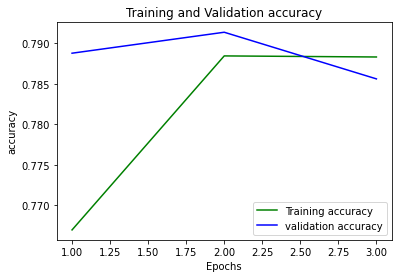

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,3+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


## Loss Graph
#loss_train = history.history['loss']
#loss_val = history.history['val_loss']
#epochs = range(1,4)
#plt.plot(epochs, loss_train, 'g', label='Training loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
#plt.title('Training loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

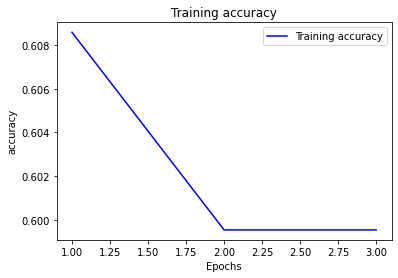

In [ ]:
## Loss Graph
loss_train = history.history['accuracy']
epochs = range(1,4)
plt.plot(epochs, loss_train, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

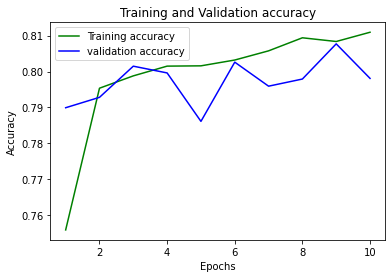

In [ ]:
## Accuracy Graph
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]))) # (time_steps, features)
model.add(BatchNormalization())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(3, activation='softmax')) # n_y
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               51200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 303       
Total params: 62,003
Trainable params: 61,803
Non-trainable params: 200
_________________________________________________________________


In [ ]:
history =  model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_test, Y_test))

Epoch 1/10
433/433 [==============================] - 86s 195ms/step - loss: 0.5285 - accuracy: 0.7425 - val_loss: 0.4624 - val_accuracy: 0.7532
Epoch 2/10
433/433 [==============================] - 84s 194ms/step - loss: 0.4013 - accuracy: 0.7990 - val_loss: 0.4919 - val_accuracy: 0.7512
Epoch 3/10
433/433 [==============================] - 84s 194ms/step - loss: 0.3856 - accuracy: 0.8075 - val_loss: 0.4559 - val_accuracy: 0.7750
Epoch 4/10
433/433 [==============================] - 85s 196ms/step - loss: 0.3790 - accuracy: 0.8107 - val_loss: 0.4444 - val_accuracy: 0.7637
Epoch 5/10
433/433 [==============================] - 85s 196ms/step - loss: 0.3727 - accuracy: 0.8135 - val_loss: 0.4027 - val_accuracy: 0.7906
Epoch 6/10
433/433 [==============================] - 85s 197ms/step - loss: 0.3702 - accuracy: 0.8164 - val_loss: 0.3831 - val_accuracy: 0.8050
Epoch 7/10
433/433 [==============================] - 85s 196ms/step - loss: 0.3618 - accuracy: 0.8189 - val_loss: 0.3854 - val_ac

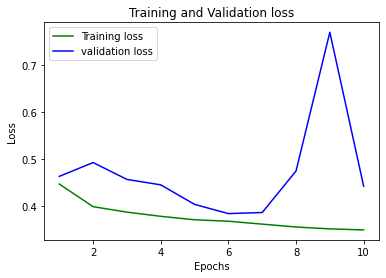

In [ ]:
## Loss Graph
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

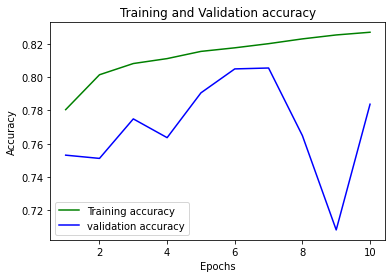

In [ ]:
## Accuracy Graph
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

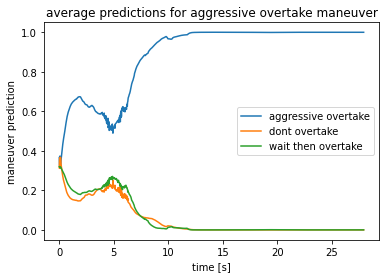

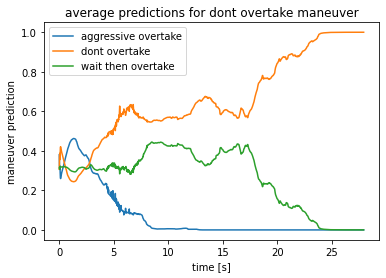

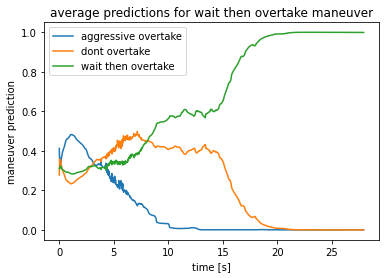

In [ ]:
# note, this cell took ~75 seconds to run on my laptop

mean_aggr = np.zeros((len(X_1s_predict[0]), 3))
mean_dont = np.zeros((len(X_1s_predict[0]), 3))
mean_wait = np.zeros((len(X_1s_predict[0]), 3))

for trial in range(99):
  X_1s_predict_array = np.array(X_1s_predict[trial]).reshape(len(X_1s_predict[trial]), 
                              X_1s_predict[trial][0].shape[0], X_1s_predict[trial][0].shape[1])
  Y_replay = model.predict(X_1s_predict_array)
  if trial < 33:
    mean_aggr += Y_replay
  elif trial < 66:
    mean_dont += Y_replay 
  else:
    mean_wait += Y_replay

# normalizing to get mean values across all 33 trials
mean_aggr /= 33
mean_dont /= 33
mean_wait /= 33

# plotting average predictions for aggressive overtake maneuver
plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 0], label = 'aggressive overtake')
plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 1], label = 'dont overtake')
plt.plot(0.02 * np.arange(mean_aggr.shape[0]), mean_aggr[:, 2], label = 'wait then overtake')
plt.legend()
plt.title('average predictions for aggressive overtake maneuver')
plt.xlabel('time [s]') 
plt.ylabel('maneuver prediction')
plt.show()

# plotting average predictions for dont overtake maneuver
plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 0], label = 'aggressive overtake')
plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 1], label = 'dont overtake')
plt.plot(0.02 * np.arange(mean_dont.shape[0]), mean_dont[:, 2], label = 'wait then overtake')
plt.legend()
plt.title('average predictions for dont overtake maneuver')
plt.xlabel('time [s]') 
plt.ylabel('maneuver prediction')
plt.show()

# plotting average predictions for wait then overtake maneuver
plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 0], label = 'aggressive overtake')
plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 1], label = 'dont overtake')
plt.plot(0.02 * np.arange(mean_wait.shape[0]), mean_wait[:, 2], label = 'wait then overtake')
plt.legend()
plt.title('average predictions for wait then overtake maneuver')
plt.xlabel('time [s]') 
plt.ylabel('maneuver prediction')
plt.show()